In [1]:
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [3]:
Battary_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battary_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheetname=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheetname=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...


D:\Program Files (x86)\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


Load datasets/CALCE/CS2_35\CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_18_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_24_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_28_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_4_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_18_10.xlsx ...
Load datasets/CALCE/C

Load datasets/CALCE/CS2_38\CS2_38_10_05_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_10_14_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_10_21_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_10_28_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_01_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_08_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_15_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_22_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_24_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_06_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_13_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_20_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_23_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_10_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_18_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_24_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_28_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_2_10_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_2_4_11.xlsx ...
Load datasets/CALCE

### 如果上面的读取数据集失败，可以通过下面的方式加载已提取出来的数据

In [3]:
Battary_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('CALCE.npy', allow_pickle=True)
Battery = Battery.item()

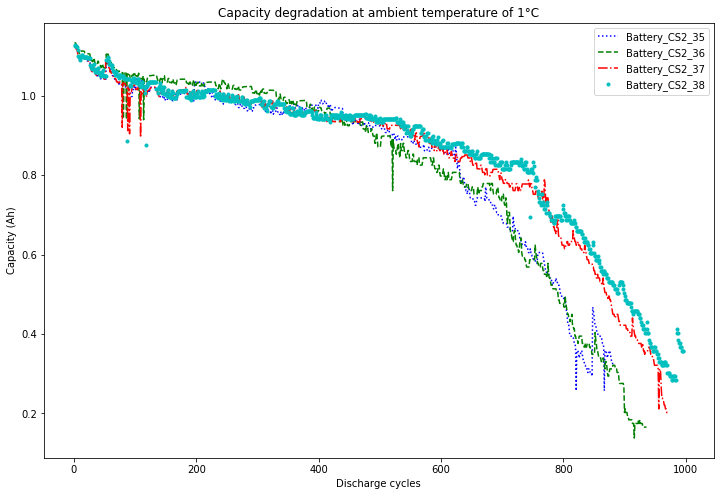

In [4]:
#Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battary_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

In [5]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, n_class=1, mode='LSTM'):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.cell = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_class)
 
    def forward(self, x):           # x shape: (batch_size, seq_len, input_size)
        out, _ = self.cell(x) 
        out = out.reshape(-1, self.hidden_dim)
        out = self.linear(out)      # out shape: (batch_size, n_class=1)
        return out

In [6]:
def tain(lr=0.001, feature_size=16, hidden_dim=128, num_layers=2, weight_decay=0.0, mode = 'LSTM', EPOCH=1000, seed=0):
    score_list, result_list = [], []
    for i in range(4):
        name = Battary_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size=feature_size)
        train_size = len(train_x)
        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = Net(input_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        mae, rmse, re = 1, 1, 1
        score_, score = 1,1
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)#(batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)# shape 为 (batch_size, 1)

            X, y = torch.from_numpy(X), torch.from_numpy(y)
            output= model(X)
            output = output.reshape(-1, 1)
            loss = criterion(output, y)
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy()    #每100次重新预测一次
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x)                           # shape: (batch_size, 1, input_size)
                    pred = model(x)
                    next_point = pred.data.numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)                          #测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)                     #保存输出序列最后一个点的预测值
                y_.append(point_list)                                 #保存本次预测所有的预测值
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            score = [re, mae, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list

In [7]:
window_size = 128
EPOCH = 1000
lr = 0.001    # learning rate  0.01 epoch 10
hidden_dim = 256
num_layers = 2
weight_decay = 0.0
mode = 'LSTM'# RNN, LSTM, GRU
Rated_Capacity = 1.1

SCORE = []
for seed in range(10):
    print('seed: ', seed)
    score_list, _ = tain(lr=lr, feature_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                         weight_decay=weight_decay, mode=mode, EPOCH=EPOCH, seed=seed)
    print('------------------------------------------------------------------')
    for s in score_list:
        SCORE.append(s)

mlist = ['re', 'mae', 'rmse']
for i in range(3):
    s = [line[i] for line in SCORE]
    print(mlist[i] + ' mean: {:<6.4f}'.format(np.mean(np.array(s))))
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')

seed:  0
sample size: 2521
epoch:99 | loss:0.0003 | MAE:0.1486 | RMSE:0.2104 | RE:1.0000
epoch:199 | loss:0.0003 | MAE:0.0917 | RMSE:0.1292 | RE:0.2510
epoch:299 | loss:0.0003 | MAE:0.0713 | RMSE:0.1027 | RE:0.1882
epoch:399 | loss:0.0003 | MAE:0.0572 | RMSE:0.0845 | RE:0.1490
epoch:499 | loss:0.0002 | MAE:0.0471 | RMSE:0.0715 | RE:0.1216
epoch:599 | loss:0.0002 | MAE:0.0405 | RMSE:0.0627 | RE:0.1039
epoch:699 | loss:0.0002 | MAE:0.0365 | RMSE:0.0569 | RE:0.0922
epoch:799 | loss:0.0002 | MAE:0.0328 | RMSE:0.0511 | RE:0.0804
epoch:899 | loss:0.0002 | MAE:0.0832 | RMSE:0.1049 | RE:0.1294
sample size: 2467
epoch:99 | loss:0.0005 | MAE:0.1123 | RMSE:0.1620 | RE:0.2466
epoch:199 | loss:0.0004 | MAE:0.3690 | RMSE:0.5049 | RE:1.0000
sample size: 2431
epoch:99 | loss:0.0004 | MAE:0.0378 | RMSE:0.0528 | RE:0.0751
epoch:199 | loss:0.0004 | MAE:0.1081 | RMSE:0.1502 | RE:0.1928
sample size: 2407
epoch:99 | loss:0.0004 | MAE:0.1570 | RMSE:0.2108 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.0717 | RM

epoch:499 | loss:0.0003 | MAE:0.1802 | RMSE:0.2426 | RE:0.2982
------------------------------------------------------------------
seed:  7
sample size: 2521
epoch:99 | loss:0.0004 | MAE:0.0373 | RMSE:0.0445 | RE:0.0569
epoch:199 | loss:0.0003 | MAE:0.0369 | RMSE:0.0567 | RE:0.0843
sample size: 2467
epoch:99 | loss:0.0006 | MAE:0.0702 | RMSE:0.1120 | RE:0.1049
epoch:199 | loss:0.0004 | MAE:0.2280 | RMSE:0.3176 | RE:1.0000
sample size: 2431
epoch:99 | loss:0.0005 | MAE:0.1637 | RMSE:0.2042 | RE:0.2969
epoch:199 | loss:0.0004 | MAE:0.1383 | RMSE:0.1849 | RE:0.2304
epoch:299 | loss:0.0004 | MAE:0.1333 | RMSE:0.1791 | RE:0.2253
epoch:399 | loss:0.0003 | MAE:0.1308 | RMSE:0.1761 | RE:0.2218
epoch:499 | loss:0.0003 | MAE:0.1236 | RMSE:0.1680 | RE:0.2116
epoch:599 | loss:0.0003 | MAE:0.1066 | RMSE:0.1472 | RE:0.1843
epoch:699 | loss:0.0002 | MAE:0.2554 | RMSE:0.3166 | RE:0.4266
sample size: 2407
epoch:99 | loss:0.0004 | MAE:0.1353 | RMSE:0.1781 | RE:0.2600
epoch:199 | loss:0.0004 | MAE:0.0462 